In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL
from skimage.filters import frangi
import random

img_path_1 = r'.\retina_images_01_10'
img_path_2 = r'.\retina_images_11_20'
mask_path = r'.\mask_images'
label_path = r'.\label_images'

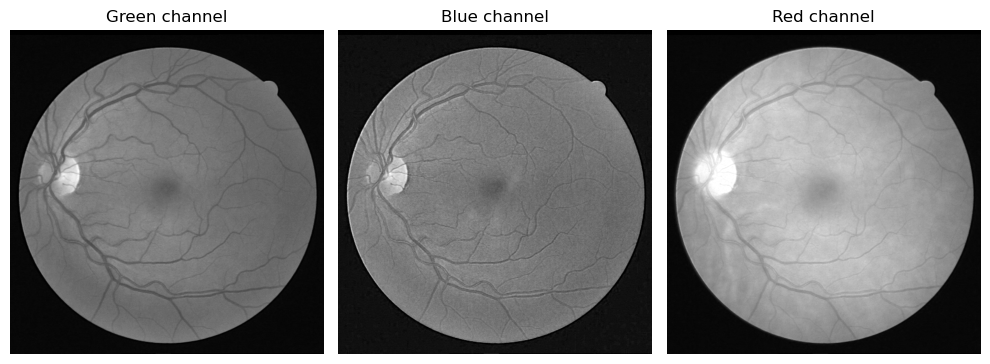

In [2]:
# To change the image number
i = 1

if i < 11:
    img = cv2.imread(os.path.join(img_path_1,str(i)+'.tif'),cv2.IMREAD_COLOR)
else:
    img = cv2.imread(os.path.join(img_path_2,str(i)+'.tif'),cv2.IMREAD_COLOR)

# extract green channel
imgGreen = img[:,:,1]
# Extract blue channel
imgBlue = img[:,:,0]
# Extract red channel
imgRed = img[:,:,2]

# Create a figure and axes
fig, axes = plt.subplots(1, 3, figsize=(10, 10))

# Display the images
axes[0].imshow(imgGreen, cmap='gray')
axes[0].set_title('Green channel')
axes[0].axis('off')  # Turn off axis labels
axes[1].imshow(imgBlue, cmap='gray')
axes[1].set_title('Blue channel')
axes[1].axis('off')  # Turn off axis labels
axes[2].imshow(imgRed, cmap='gray')
axes[2].set_title('Red channel')
axes[2].axis('off')  # Turn off axis labels

# Adjust layout and display
plt.tight_layout()
plt.show()

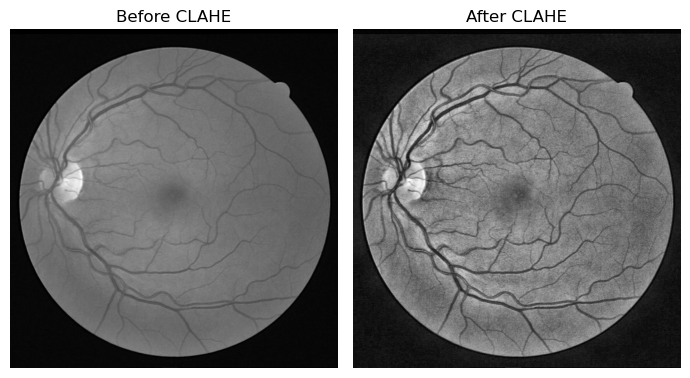

In [3]:
# Apply CLAHE to the green channel image
clahe = cv2.createCLAHE(clipLimit=3.5, tileGridSize=(20, 20))
imgEqualized = clahe.apply(imgGreen)

# Create a figure and axes
fig, axes = plt.subplots(1, 2, figsize=(7, 7))

# Display the images
axes[0].imshow(imgGreen, cmap='gray')
axes[0].set_title('Before CLAHE')
axes[0].axis('off')  # Turn off axis labels
axes[1].imshow(imgEqualized, cmap='gray')
axes[1].set_title('After CLAHE')
axes[1].axis('off')  # Turn off axis labels
# Adjust layout and display
plt.tight_layout()
plt.show()

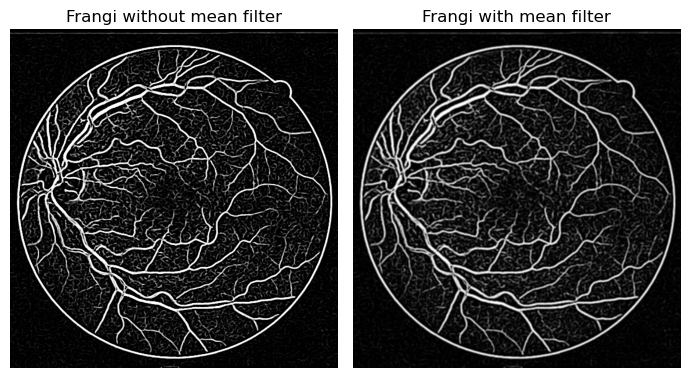

In [4]:
# apply Frangi to enhance vessels
sigmas = (0.5, 1.4, 1.5)  # Range of sigmas to use
scale_step = 1 # Step size between sigmas
beta = 1  # Frangi correction constant
imgFrangi = frangi(imgEqualized, sigmas=sigmas, scale_step=scale_step, beta=beta)
imgFrangi1 = (imgFrangi * 255).astype(np.uint8) # change frangi data type to uint8
# apply median filter
imgFrangi = cv2.blur(imgFrangi1, (3,3), 0)
# Create a figure and axes
fig, axes = plt.subplots(1, 2, figsize=(7, 7))

# Display the images
axes[0].imshow(imgFrangi1, cmap='gray')
axes[0].set_title('Frangi without mean filter')
axes[0].axis('off')  # Turn off axis labels
axes[1].imshow(imgFrangi, cmap='gray')
axes[1].set_title('Frangi with mean filter')
axes[1].axis('off')  # Turn off axis labels

# Adjust layout and display
plt.tight_layout()
plt.show()

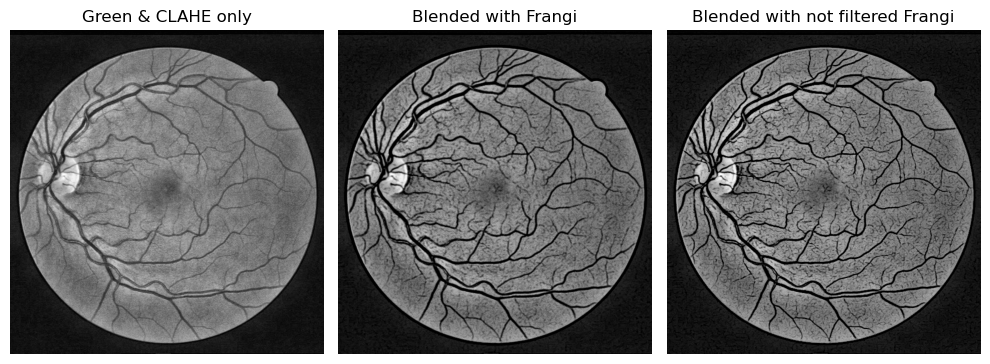

In [5]:
# blend image with inverted blurred frangi
imgWeighted = cv2.addWeighted(imgEqualized, 1, imgFrangi, -0.41, 0)

# blend image with inverted frangi only
imgWeighted2 = cv2.addWeighted(imgEqualized, 1, imgFrangi1, -0.41, 0)

# Create a figure and axes
fig, axes = plt.subplots(1, 3, figsize=(10, 10))

# Display the images
axes[0].imshow(imgEqualized, cmap='gray')
axes[0].set_title('Green & CLAHE only')
axes[0].axis('off')  # Turn off axis labels
axes[1].imshow(imgWeighted, cmap='gray')
axes[1].set_title('Blended with Frangi')
axes[1].axis('off')  # Turn off axis labels
axes[2].imshow(imgWeighted2, cmap='gray')
axes[2].set_title('Blended with not filtered Frangi')
axes[2].axis('off')  # Turn off axis labels


# Adjust layout and display
plt.tight_layout()
plt.show()

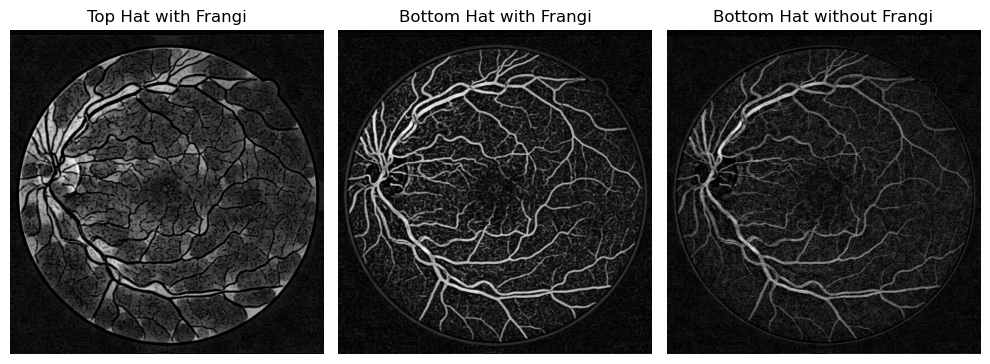

In [6]:
# top bottom hat to enhance dark vessels (with frangi)
kernel_size = (20, 20)
structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
imgTophat = cv2.morphologyEx(imgWeighted, cv2.MORPH_TOPHAT, structuring_element)

# bottom hat to enhance dark vessels (with frangi)
kernel_size = (13, 13)
structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
imgBottomhat = cv2.morphologyEx(imgWeighted, cv2.MORPH_BLACKHAT, structuring_element)

# bottom hat without frangi
imgBottomhat2 = cv2.morphologyEx(imgEqualized, cv2.MORPH_BLACKHAT, structuring_element)


# Create a figure and axes
fig, axes = plt.subplots(1, 3, figsize=(10, 10))

# Display the images
axes[0].imshow(imgTophat, cmap='gray')
axes[0].set_title('Top Hat with Frangi')
axes[0].axis('off')  # Turn off axis labels
axes[1].imshow(imgBottomhat, cmap='gray')
axes[1].set_title('Bottom Hat with Frangi')
axes[1].axis('off')  # Turn off axis labels
axes[2].imshow(imgBottomhat2, cmap='gray')
axes[2].set_title('Bottom Hat without Frangi')
axes[2].axis('off')  # Turn off axis labels

# Adjust layout and display
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Image after Masking')

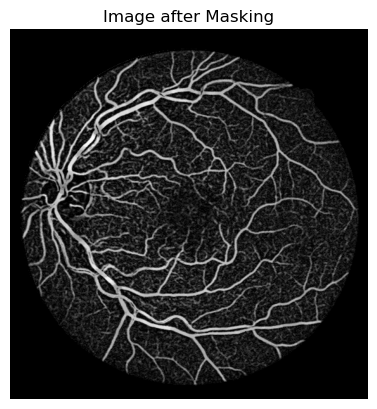

In [7]:
# load and preprocess mask
mask = PIL.Image.open(os.path.join(mask_path,str(i)+'.tif'))
mask = np.array(mask)
# apply mask to image
imgMasked = np.multiply(imgBottomhat,mask/255).astype(np.uint8)

plt.imshow(imgMasked, cmap='gray')
plt.axis('off')
plt.title("Image after Masking")

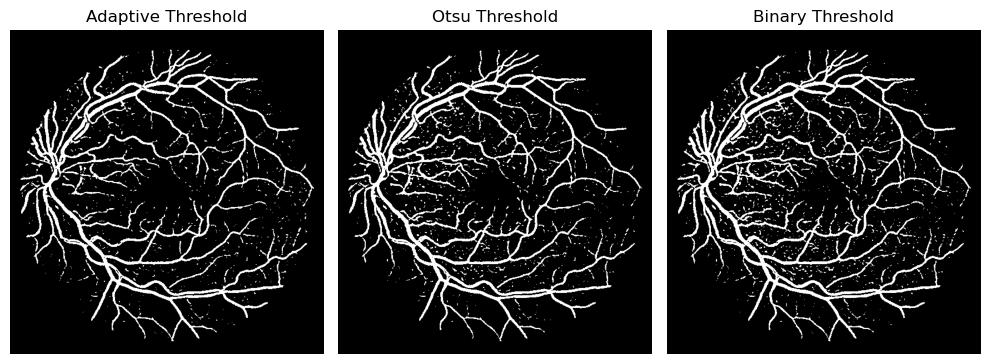

In [8]:
# threshold image
# otsu threshold
_, otsuThreshold = cv2.threshold(imgMasked, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# binary threshold
_, binaryThreshold = cv2.threshold(imgMasked,60, 255, cv2.THRESH_BINARY)

# Apply adaptive thresholding globally to whole image with threshold calculated as mean value
imgAdaptiveThreshold = cv2.adaptiveThreshold(imgMasked, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, blockSize=257, C=-39)

# Create a figure and axes
fig, axes = plt.subplots(1, 3, figsize=(10, 10))

# Display the images
axes[0].imshow(imgAdaptiveThreshold, cmap='gray')
axes[0].set_title('Adaptive Threshold')
axes[0].axis('off')  # Turn off axis labels
axes[1].imshow(otsuThreshold , cmap='gray')
axes[1].set_title('Otsu Threshold')
axes[1].axis('off')  # Turn off axis labels
axes[2].imshow(binaryThreshold , cmap='gray')
axes[2].set_title('Binary Threshold')
axes[2].axis('off')  # Turn off axis labels

# Adjust layout and display
plt.tight_layout()
plt.show()

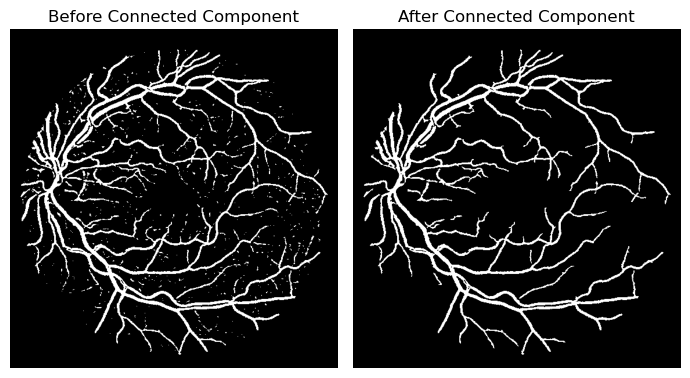

In [9]:
def connectedComponent(image, threshold=50):
    # change image type to uint8
    image = image.astype(np.uint8)
    # apply connected component analysis function
    totalLabels, labels, stats, _ = cv2.connectedComponentsWithStats(image, connectivity=4)
    
    # initialised filtered image with 0
    filtered = np.zeros_like(image)
    
    # maintain only the ones analyse as vessels
    for i in range(1, totalLabels):
        if stats[i, cv2.CC_STAT_AREA] >= threshold:
            filtered[labels == i] = 1  # make binary image of 0 and 1 only
    return filtered
    
# apply connected component filter
imgConnectedComponent = connectedComponent(imgAdaptiveThreshold, 48)

# Create a figure and axes
fig, axes = plt.subplots(1, 2, figsize=(7, 7))

# Display the images
axes[0].imshow(imgAdaptiveThreshold, cmap='gray')
axes[0].set_title('Before Connected Component')
axes[0].axis('off')  # Turn off axis labels
axes[1].imshow(imgConnectedComponent , cmap='gray')
axes[1].set_title('After Connected Component')
axes[1].axis('off')  # Turn off axis labels

# Adjust layout and display
plt.tight_layout()
plt.show()

In [10]:
# load label images
label = PIL.Image.open(os.path.join(label_path,str(i)+'.tif'))
label = np.array(label)

In [11]:
# calculate accuracy(T), sensitivity(P), specificity(N)
TP = sum(sum((label==255) & (imgConnectedComponent==1) & (mask == 255)))
TN = sum(sum((label==0) & (imgConnectedComponent==0) & (mask == 255)))
FP = sum(sum((label==0) & (imgConnectedComponent==1) & (mask == 255)))
FN = sum(sum((label==255) & (imgConnectedComponent==0) & (mask == 255)))
P = TP/(TP+FN)
N = TN/(TN+FP)
T = (TP+TN)/(TP+FN+TN+FP)

In [12]:
P

0.8208554331565348

In [13]:
N

0.9696253173646552

In [14]:
T

0.950124121456299

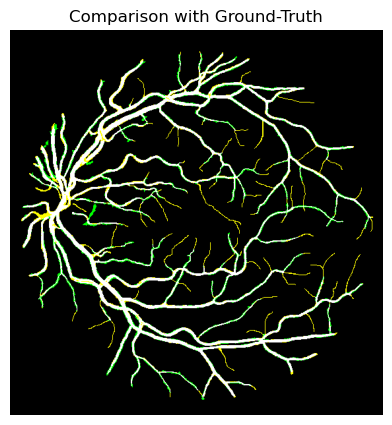

In [15]:
# show comparison with label image
comparison = np.zeros((*imgConnectedComponent.shape, 3), dtype=np.uint8)

# Define colors for TP, FP, FN, and TN
white = [255, 255, 255]  # True Positive
green = [0, 255, 0]      # False Positive
yellow = [255, 255, 0]    # False Negative
black = [0, 0, 0]  # True Negative

# Identify the differences
TP = (label==255) & (imgConnectedComponent==1) & (mask == 255)
TN = (label==0) & (imgConnectedComponent==0) & (mask == 255)
FP = (label==0) & (imgConnectedComponent==1) & (mask == 255)
FN = (label==255) & (imgConnectedComponent==0) & (mask == 255)

# Assign colors
comparison[TP] = white
comparison[FP] = green
comparison[FN] = yellow
comparison[TN] = black

# Convert to PIL image for easier visualization
comparison_img = PIL.Image.fromarray(comparison)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(comparison_img)
ax.set_title('Comparison with Ground-Truth')
ax.axis('off')
plt.show()

P Average:  0.7292913074084323
N Average:  0.9807368429419656
T Average:  0.9484372591674299


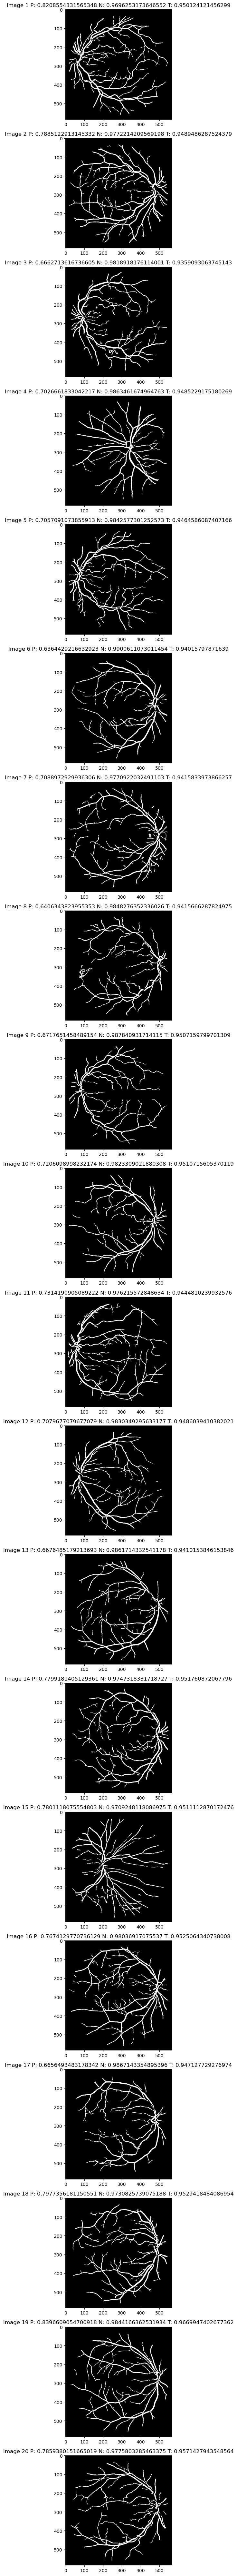

In [29]:
random.seed(0)
P_total, N_total, T_total = 0., 0., 0.
fig, axs = plt.subplots(20, 1, figsize=(15, 80))

# connected component analysis function
def connectedComponent(image, threshold=50):
    # change image type to uint8
    image = image.astype(np.uint8)
    # apply connected component analysis function
    totalLabels, labels, stats, _ = cv2.connectedComponentsWithStats(image, connectivity=4)
    
    # initialised filtered image with 0
    filtered = np.zeros_like(image)
    
    # maintain only the ones analyse as vessels
    for i in range(1, totalLabels):
        if stats[i, cv2.CC_STAT_AREA] >= threshold:
            filtered[labels == i] = 1  # make binary image of 0 and 1 only
    return filtered
    
for i in range(1, 21):
    # Load input image
    if i < 11:
        img = cv2.imread(os.path.join(img_path_1,str(i)+'.tif'),cv2.IMREAD_COLOR)
    else:
        img = cv2.imread(os.path.join(img_path_2,str(i)+'.tif'),cv2.IMREAD_COLOR)
        
    # Segment the retina blood vessel
    # extract green channel
    imgGreen = img[:,:,1]

    # enhance contrast of image and preserve local details using CLAHE
    clahe = cv2.createCLAHE(clipLimit=3.5, tileGridSize=(20, 20))
    imgEqualized = clahe.apply(imgGreen)
    
    # frangi to enhance vessels
    sigmas = (0.5, 1.4, 1.5)  # Range of sigmas to use
    scale_step = 1 # Step size between sigmas
    beta = 1  # Frangi correction constant
    imgFrangi = frangi(imgEqualized, sigmas=sigmas, scale_step=scale_step, beta=beta)
    imgFrangi = (imgFrangi * 255).astype(np.uint8)

    # mean filter to reduce noise
    imgFrangi = cv2.blur(imgFrangi, (3,3), 0)
    
    # blend frangi with equalized image to increase contrast of vessels
    imgWeighted = cv2.addWeighted(imgEqualized, 1, imgFrangi, -0.41, 0)

    # bottom hat to enhance dark vessels into white colour
    kernel_size = (13, 13)
    structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    imgBottomhat = cv2.morphologyEx(imgWeighted, cv2.MORPH_BLACKHAT, structuring_element)

    # Load and Preprocess the mask
    mask = np.array(PIL.Image.open(os.path.join(mask_path,str(i)+'.tif')))
    imgMasked = np.multiply(imgBottomhat,mask/255).astype(np.uint8)
    
    # Apply adaptive thresholding globally to whole image with threshold calculated as mean value
    imgAdaptiveThreshold = cv2.adaptiveThreshold(imgMasked, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, blockSize=257, C=-39)

    # use connected component to remove background noise
    imgConnectedComponent = connectedComponent(imgAdaptiveThreshold, 48)
        
    # Load the label
    label = np.array(PIL.Image.open(os.path.join(label_path,str(i)+'.tif')))

    # calculate accuracy(T), sensitivity(P), specificity(N)
    TP = sum(sum((label==255) & (imgConnectedComponent==1) & (mask == 255)))
    TN = sum(sum((label==0) & (imgConnectedComponent==0) & (mask == 255)))
    FP = sum(sum((label==0) & (imgConnectedComponent==1) & (mask == 255)))
    FN = sum(sum((label==255) & (imgConnectedComponent==0) & (mask == 255)))
    P_total += TP/(TP+FN)
    N_total += TN/(TN+FP)
    T_total += (TP+TN)/(TP+FN+TN+FP)

    # print all images with title
    ax = axs[i-1]
    ax.imshow(imgConnectedComponent, cmap='gray')
    ax.set_title(f'Image {i} P: {TP/(TP+FN)} N: {TN/(TN+FP)} T: {(TP+TN)/(TP+FN+TN+FP)}')

print('P Average: ', P_total/20)
print('N Average: ', N_total/20)
print('T Average: ', T_total/20)

plt.tight_layout()
plt.show()